## **Setup environment**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')


Mounted at /content/gdrive/


In [3]:
import os
import datetime
import numpy as np

import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.optimizers import *
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import itertools
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.svm import SVC, LinearSVC
from sklearn.utils import class_weight

#Da fare o no?
np.random.seed(42)
tf.random.set_seed(42)


2.4.0


In [4]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

# 5.1 Ensemble Method for Mass Calcification Classification

## Prepare Learning Dataset





In [7]:
#Load learning sets
import numpy as np
out_path = '/content/gdrive/My Drive/Balestri_Silvestri/numpy data'

def load_test():
  images = np.load(os.path.join(out_path,'public_test_tensor.npy'))
  labels = np.load(os.path.join(out_path,'public_test_labels.npy'))
  return images,labels

grayscale_test_images, test_labels = load_test()
test_images = np.repeat(grayscale_test_images[..., np.newaxis], 3, -1)
print("Test set loaded")
print("Test Images:" + str(np.shape(test_images)))
print("Test Labels:" +str(np.shape(test_labels)))

test_images_1ch, test_labels_1ch = load_test()
test_images_1ch = np.expand_dims(test_images_1ch, axis = 3)
print("Test set loaded")
print("Test Images:" + str(np.shape(test_images_1ch)))
print("Test Labels:" +str(np.shape(test_labels_1ch)))

Test set loaded
Test Images:(672, 150, 150, 3)
Test Labels:(672,)
Test set loaded
Test Images:(672, 150, 150, 1)
Test Labels:(672,)


In [8]:
#TEST SET
#extract all anormalities indexes
test_indexes = np.where(test_labels != 0)

#extract all corrispondent anormalities images and labels
test_images = np.take(test_images, test_indexes[0], 0)
test_labels = np.take(test_labels, test_indexes[0], 0)

#Change labels according to Benign and Malignant
test_labels = np.where(np.logical_or(test_labels == 1, test_labels == 2), 0, test_labels)
test_labels = np.where(np.logical_or(test_labels == 3, test_labels == 4), 1, test_labels)

test_class0 = (test_labels == 0).sum()
test_class1 = (test_labels == 1).sum()

print("Test Set")
print("Test Images:" + str(np.shape(test_images)))
print("Test Labels:" + str(np.shape(test_labels)))
print (str(test_class0) + " belonging to class 0 in the test set")
print (str(test_class1) + " belonging to class 1 in the test set")

#TEST SET 1 CHANNEL
#extract all anormalities indexes
test_indexes_1ch = np.where(test_labels_1ch != 0)

#extract all corrispondent anormalities images and labels
test_images_1ch = np.take(test_images_1ch, test_indexes_1ch[0], 0)
test_labels_1ch = np.take(test_labels_1ch, test_indexes_1ch[0], 0)

#Change labels according to Benign and Malignant
test_labels_1ch = np.where(np.logical_or(test_labels_1ch == 1, test_labels_1ch == 2), 0, test_labels_1ch)
test_labels_1ch = np.where(np.logical_or(test_labels_1ch == 3, test_labels_1ch == 4), 1, test_labels_1ch)

test_class0_1ch = (test_labels_1ch == 0).sum()
test_class1_1ch = (test_labels_1ch == 1).sum()

print("Test Set 1CH")
print("Test Images:" + str(np.shape(test_images_1ch)))
print("Test Labels:" + str(np.shape(test_labels_1ch)))
print (str(test_class0_1ch) + " belonging to class 0 in the test set")
print (str(test_class1_1ch) + " belonging to class 1 in the test set")

Test Set
Test Images:(336, 150, 150, 3)
Test Labels:(336,)
179 belonging to class 0 in the test set
157 belonging to class 1 in the test set
Test Set 1CH
Test Images:(336, 150, 150, 1)
Test Labels:(336,)
179 belonging to class 0 in the test set
157 belonging to class 1 in the test set


In [9]:
BATCH_SIZE = 32

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./65535)

test_dataset = test_datagen.flow(
    test_images,
    test_labels,
    batch_size=BATCH_SIZE,
    shuffle = False
)

test_dataset_1ch = test_datagen.flow(
    test_images_1ch,
    test_labels_1ch,
    batch_size=BATCH_SIZE,
    shuffle = False
)

##Evaluation of single models


In [11]:
pretrained_path = "/content/gdrive/My Drive/Balestri_Silvestri/models/Pretrained_CNN_mass_calc/"
scratch_path = "/content/gdrive/My Drive/Balestri_Silvestri/models/Scratch_CNN_mass_calc/"
vgg_16_finetuned = load_model(os.path.join(pretrained_path, 'VGG16_finetuned.h5'))
vgg_19_finetuned = load_model(os.path.join(pretrained_path, 'VGG19_finetuned.h5'))

alexnet_fromscratch = load_model(os.path.join(scratch_path, 'SimpleAlexNet_7_best.h5'))
vgg16_fromscratch = load_model(os.path.join(scratch_path, 'vgg16_4.h5'))
simple_fromscratch = load_model(os.path.join(scratch_path, 'SimpleCNN_1_best.h5'))

pretrained = [vgg_16_finetuned, vgg_19_finetuned]
scratch =[alexnet_fromscratch,vgg16_fromscratch,simple_fromscratch]

11/11 [==============================] - 1s 63ms/step - loss: 0.3737 - acc: 0.8899
0.8898809552192688
[[157  22]
 [ 15 142]]


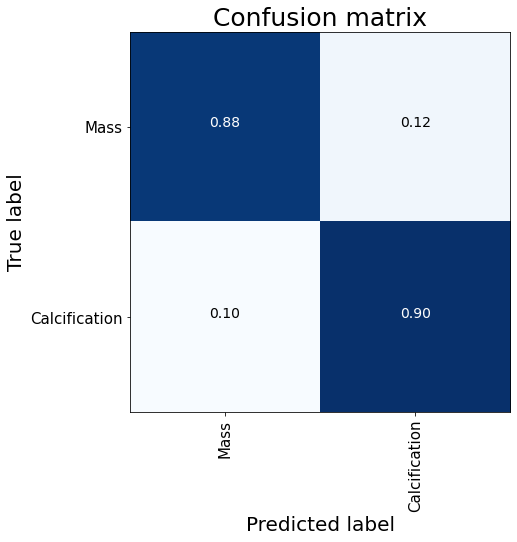

              precision    recall  f1-score   support

           0       0.91      0.88      0.89       179
           1       0.87      0.90      0.88       157

    accuracy                           0.89       336
   macro avg       0.89      0.89      0.89       336
weighted avg       0.89      0.89      0.89       336

[[157  22]
 [ 15 142]]
11/11 [==============================] - 1s 73ms/step - loss: 0.3423 - acc: 0.8780
0.8779761791229248
[[157  22]
 [ 19 138]]


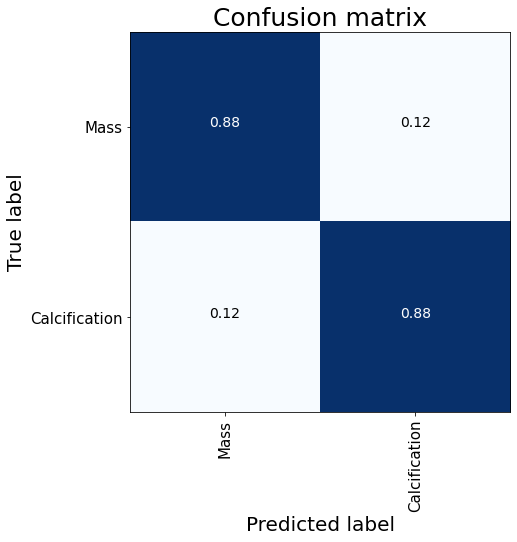

              precision    recall  f1-score   support

           0       0.89      0.88      0.88       179
           1       0.86      0.88      0.87       157

    accuracy                           0.88       336
   macro avg       0.88      0.88      0.88       336
weighted avg       0.88      0.88      0.88       336

[[157  22]
 [ 19 138]]


In [ ]:
for model in pretrained:
  test_loss, test_accuracy = model.evaluate(test_dataset)
  print(test_accuracy)
  pred_labels = (model.predict(test_dataset) > 0.5).astype("int32")
  conf_matrix = confusion_matrix(test_labels, pred_labels)
  print(conf_matrix)
  plt.figure(figsize=(7,7))
  plot_confusion_matrix( conf_matrix, classes=['Mass','Calcification'], title="Confusion matrix")
  plt.show()
  print(sklearn.metrics.classification_report(test_labels, pred_labels))
  print(conf_matrix)

11/11 [==============================] - 1s 65ms/step - loss: 0.3066 - acc: 0.8810
0.8809523582458496


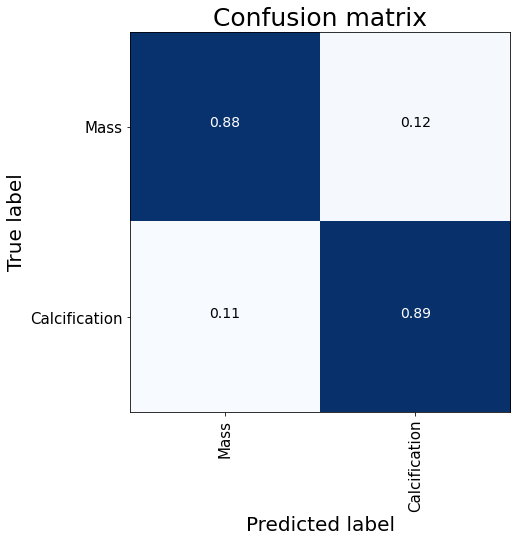

[[157  22]
 [ 18 139]]
11/11 [==============================] - 1s 65ms/step - loss: 0.3064 - acc: 0.8810
0.8809523582458496


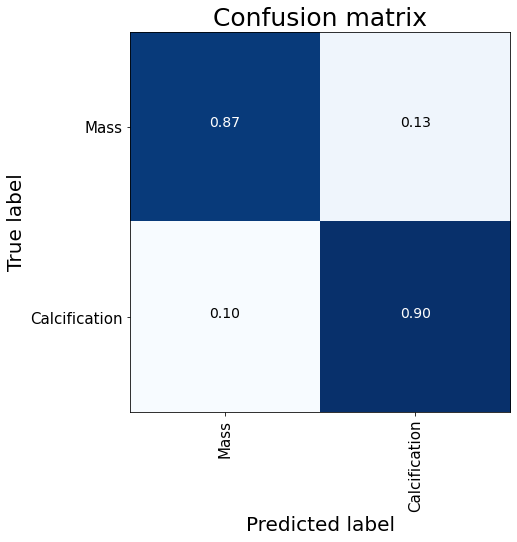

[[155  24]
 [ 16 141]]
11/11 [==============================] - 0s 14ms/step - loss: 0.3700 - acc: 0.8452
0.8452380895614624


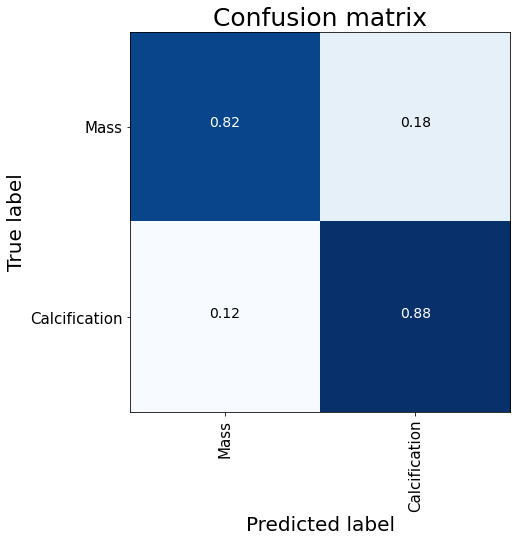

[[146  33]
 [ 19 138]]


In [ ]:
for model in scratch:
  test_loss, test_accuracy = model.evaluate(test_dataset_1ch)
  print(test_accuracy)
  pred_labels = (model.predict(test_dataset_1ch) > 0.5).astype("int32")
  conf_matrix = confusion_matrix(test_labels_1ch, pred_labels)
  plt.figure(figsize=(7,7))
  plot_confusion_matrix( conf_matrix, classes=['Mass','Calcification'], title="Confusion matrix")
  plt.show()
  print(conf_matrix)

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


pred_vgg16=vgg_16_finetuned.predict(test_dataset)
fpr_vgg16fe, tpr_vgg16fe, thresholds_vgg16fe = roc_curve(test_labels,pred_vgg16)
auc_vgg16fe = auc(fpr_vgg16fe, tpr_vgg16fe)

pred_vgg16we=vgg_19_finetuned.predict(test_dataset)
fpr_vgg16we, tpr_vgg16we, thresholds_vgg16we = roc_curve(test_labels,pred_vgg16we)
auc_vgg16we = auc(fpr_vgg16we, tpr_vgg16we)

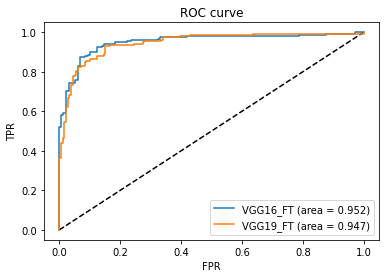

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_vgg16fe, tpr_vgg16fe, label='VGG16_FT (area = {:.3f})'.format(auc_vgg16fe))
plt.plot(fpr_vgg16we, tpr_vgg16we, label='VGG19_FT (area = {:.3f})'.format(auc_vgg16we))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


## Evaluation of Average Voting / Majority Voting ensemble Methods

In [12]:
preds_pret= [model.predict(test_dataset) for model in pretrained]
preds_pret= np.array(preds_pret)
pret_sum_pred=np.sum(preds_pret,axis=0)
pret_votes=np.where(preds_pret > 0.5, 1, 0)
pret_votes=np.sum(pret_votes,axis=0)


scratch_preds= [model.predict(test_dataset_1ch) for model in scratch]
scratch_preds= np.array(scratch_preds)
scratch_sum_pred=np.sum(scratch_preds,axis=0)
scratch_votes=np.where(scratch_preds > 0.5, 1, 0)
scratch_votes=np.sum(scratch_votes,axis=0)



Accuracy: 0.8898809523809523


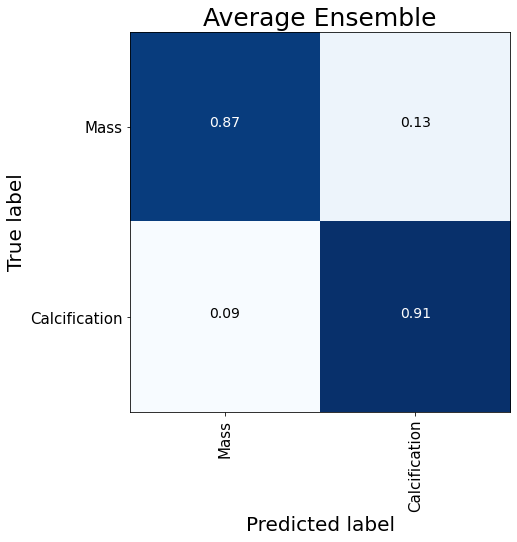

[[156  23]
 [ 14 143]]


In [13]:
avg_pred=(scratch_sum_pred+pret_sum_pred)/(len(scratch)+len(pretrained))


pred_labels = (avg_pred > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
print("Accuracy: " + str(accuracy_score(test_labels, pred_labels)))
plt.figure(figsize=(7,7))
plot_confusion_matrix( conf_matrix, classes=['Mass','Calcification'], title="Average Ensemble")
plt.show()
print(conf_matrix)

Accuracy: 0.8869047619047619


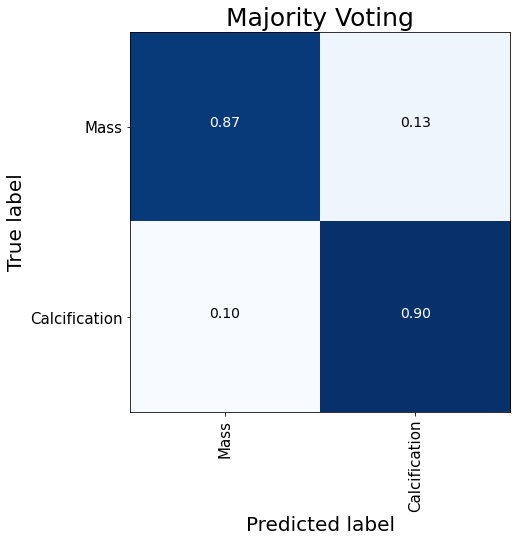

[[156  23]
 [ 15 142]]


In [ ]:
vote=(pret_votes+scratch_votes)/(len(scratch)+len(pretrained))

pred_labels = (vote > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
print("Accuracy: " + str(accuracy_score(test_labels, pred_labels)))
plt.figure(figsize=(7,7))
plot_confusion_matrix( conf_matrix, classes=['Mass','Calcification'], title="Majority Voting")
plt.show()
print(conf_matrix)

## Weighted Average Ensemble On Pretrained_CNN results

https://machinelearningmastery.com/weighted-average-ensemble-for-deep-learning-neural-networks/

In [ ]:
def ensemble_predictions(members, weights, test):
	# make predictions
	yhats = [model.predict(test) for model in members]
	yhats = np.array(yhats)
	# weighted sum across ensemble members
	result = np.tensordot(yhats, weights, axes=((0),(0)))
	# argmax across classes
	return result

def evaluate_ensemble(members, weights, testset, testlab):
  # make prediction
  yhat = ensemble_predictions(members, weights, testset)
  pred_labels=(yhat > 0.5).astype("int32")
  return accuracy_score(testlab, pred_labels)

def normalize(weights):
  result=np.linalg.norm(weights,1)
  if result == 0.0:
	  return weights
  return weights/result

def grid_search(members, testset, testlab):
	# define weights to consider
	w = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
	best_score, best_weights = 0.0, None
	# iterate all possible combinations (cartesian product)
	for weights in itertools.product(w, repeat=len(members)):
		# skip if all weights are equal
		if len(set(weights)) == 1:
			continue
		# hack, normalize weight vector
		weights = normalize(weights)
		# evaluate weights
		score = evaluate_ensemble(members, weights, testset, testlab)
		if score > best_score:
			best_score, best_weights = score, weights
			print('>%s %.3f' % (best_weights, best_score))
	return list(best_weights)

In [ ]:
stweights = [1.0/len(pretrained) for _ in range(len(pretrained))]
score = evaluate_ensemble(pretrained, stweights, test_dataset, test_labels)
print("Same Weight Accuracy: " + str(score))
weights = grid_search(pretrained, test_dataset, test_labels)
score = evaluate_ensemble(pretrained, weights, test_dataset, test_labels)

Same Weight Accuracy: 0.9077380952380952
>[0. 1.] 0.878
>[1. 0.] 0.890
>[0.33333333 0.66666667] 0.896
>[0.4 0.6] 0.899
>[0.6 0.4] 0.905


We can observe that assigning the same weight to the two pretrained models will lead to a better result on the public test set. <br>
The performance score of this ensemble method is better of the one including trained from scrap models (On this public test set).

Weights: [0.5, 0.5]
Accuracy: 0.9077380952380952
              precision    recall  f1-score   support

           0       0.92      0.91      0.91       179
           1       0.89      0.91      0.90       157

    accuracy                           0.91       336
   macro avg       0.91      0.91      0.91       336
weighted avg       0.91      0.91      0.91       336



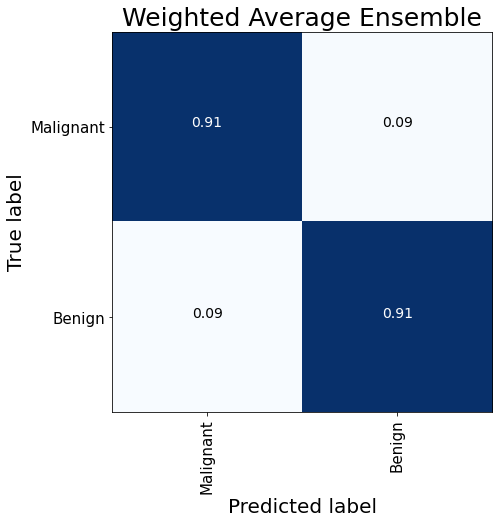

In [ ]:
print("Weights: " + str(stweights))
res=ensemble_predictions(pretrained, stweights, test_dataset)
pred_labels = (res > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
print("Accuracy: " + str(accuracy_score(test_labels, pred_labels)))
print(sklearn.metrics.classification_report(test_labels, pred_labels))
plt.figure(figsize=(7,7))
plot_confusion_matrix( conf_matrix, classes=['Malignant','Benign'], title="Weighted Average Ensemble")
plt.show()

# 5.2 Ensemble Method for Benign Malignant Classification

## Prepare Learning Dataset





In [ ]:
#Load learning sets
import numpy as np
out_path = '/content/gdrive/My Drive/Balestri_Silvestri/numpy data'

def load_test():
  images = np.load(os.path.join(out_path,'public_test_tensor.npy'))
  labels = np.load(os.path.join(out_path,'public_test_labels.npy'))
  return images,labels

grayscale_test_images, test_labels = load_test()
test_images = np.repeat(grayscale_test_images[..., np.newaxis], 3, -1)
print("Test set loaded")
print("Test Images:" + str(np.shape(test_images)))
print("Test Labels:" +str(np.shape(test_labels)))

test_images_1ch, test_labels_1ch = load_test()
test_images_1ch = np.expand_dims(test_images_1ch, axis = 3)
print("Test set loaded")
print("Test Images:" + str(np.shape(test_images_1ch)))
print("Test Labels:" +str(np.shape(test_labels_1ch)))

Test set loaded
Test Images:(672, 150, 150, 3)
Test Labels:(672,)
Test set loaded
Test Images:(672, 150, 150, 1)
Test Labels:(672,)


In [ ]:
#TEST SET
#extract all anormalities indexes
test_indexes = np.where(test_labels != 0)

#extract all corrispondent anormalities images and labels
test_images = np.take(test_images, test_indexes[0], 0)
test_labels = np.take(test_labels, test_indexes[0], 0)

#Change labels according to Benign and Malignant
test_labels = np.where(np.logical_or(test_labels == 1, test_labels == 3), 1, test_labels)
test_labels = np.where(np.logical_or(test_labels == 2, test_labels == 4), 0, test_labels)

test_class0 = (test_labels == 0).sum()
test_class1 = (test_labels == 1).sum()

print("Test Set")
print("Test Images:" + str(np.shape(test_images)))
print("Test Labels:" + str(np.shape(test_labels)))
print (str(test_class0) + " belonging to class 0 in the test set")
print (str(test_class1) + " belonging to class 1 in the test set")

#TEST SET 1 CHANNEL
#extract all anormalities indexes
test_indexes_1ch = np.where(test_labels_1ch != 0)

#extract all corrispondent anormalities images and labels
test_images_1ch = np.take(test_images_1ch, test_indexes_1ch[0], 0)
test_labels_1ch = np.take(test_labels_1ch, test_indexes_1ch[0], 0)

#Change labels according to Benign and Malignant
test_labels_1ch = np.where(np.logical_or(test_labels_1ch == 1, test_labels_1ch == 3), 0, test_labels_1ch)
test_labels_1ch = np.where(np.logical_or(test_labels_1ch == 2, test_labels_1ch == 4), 1, test_labels_1ch)

test_class0_1ch = (test_labels_1ch == 0).sum()
test_class1_1ch = (test_labels_1ch == 1).sum()

print("Test Set 1CH")
print("Test Images:" + str(np.shape(test_images_1ch)))
print("Test Labels:" + str(np.shape(test_labels_1ch)))
print (str(test_class0_1ch) + " belonging to class 0 in the test set")
print (str(test_class1_1ch) + " belonging to class 1 in the test set")

Test Set
Test Images:(336, 150, 150, 3)
Test Labels:(336,)
117 belonging to class 0 in the test set
219 belonging to class 1 in the test set
Test Set 1CH
Test Images:(336, 150, 150, 1)
Test Labels:(336,)
219 belonging to class 0 in the test set
117 belonging to class 1 in the test set


In [ ]:
BATCH_SIZE = 32

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./65535)

test_dataset = test_datagen.flow(
    test_images,
    test_labels,
    batch_size=BATCH_SIZE,
    shuffle = False
)

test_dataset_1ch = test_datagen.flow(
    test_images_1ch,
    test_labels_1ch,
    batch_size=BATCH_SIZE,
    shuffle = False
)

##Evaluation of single models


In [ ]:
pretrained_path = "/content/gdrive/My Drive/Balestri_Silvestri/models/Pretrained_CNN_benign_malignant/"
scratch_path = "/content/gdrive/My Drive/Balestri_Silvestri/models/Scratch_CNN_ben_mal/"
vgg_16_featextraction = load_model(os.path.join(pretrained_path, 'VGG16_featextraction.h5'))
vgg_19_featextraction = load_model(os.path.join(pretrained_path, 'VGG19_featextraction.h5'))
vgg_16_ftweighted = load_model(os.path.join(pretrained_path, 'VGG16_finetuned3step.h5'))


alexnet_fromscratch = load_model(os.path.join(scratch_path, 'SimpleAlexNet_4_best.h5'))
vgg16_fromscratch = load_model(os.path.join(scratch_path, 'vgg16_4_best.h5'))
simple_fromscratch = load_model(os.path.join(scratch_path, 'SimpleCNN_4_best.h5'))

pretrained = [vgg_16_featextraction, vgg_19_featextraction,vgg_16_ftweighted]
scratch =[alexnet_fromscratch,vgg16_fromscratch,simple_fromscratch]

11/11 [==============================] - 9s 112ms/step - loss: 0.5820 - acc: 0.7113
0.711309552192688
              precision    recall  f1-score   support

           0       0.60      0.50      0.55       117
           1       0.76      0.82      0.79       219

    accuracy                           0.71       336
   macro avg       0.68      0.66      0.67       336
weighted avg       0.70      0.71      0.70       336



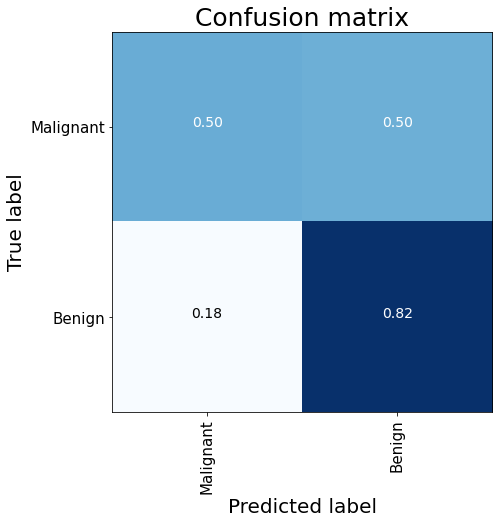

11/11 [==============================] - 1s 75ms/step - loss: 0.5992 - acc: 0.6845
0.6845238208770752
              precision    recall  f1-score   support

           0       0.56      0.45      0.50       117
           1       0.73      0.81      0.77       219

    accuracy                           0.68       336
   macro avg       0.65      0.63      0.63       336
weighted avg       0.67      0.68      0.68       336



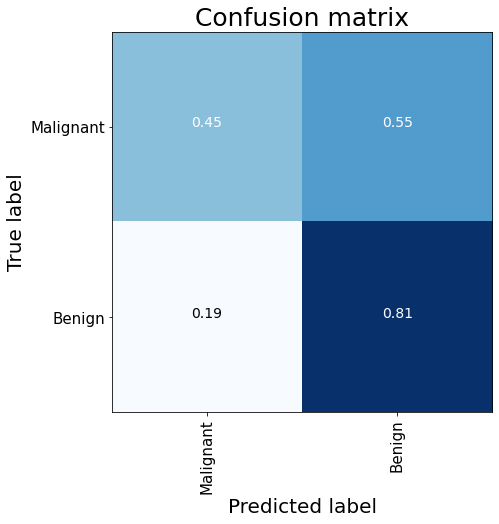

11/11 [==============================] - 1s 63ms/step - loss: 0.5991 - acc: 0.7173
0.7172619104385376
              precision    recall  f1-score   support

           0       0.59      0.63      0.61       117
           1       0.80      0.76      0.78       219

    accuracy                           0.72       336
   macro avg       0.69      0.70      0.69       336
weighted avg       0.72      0.72      0.72       336



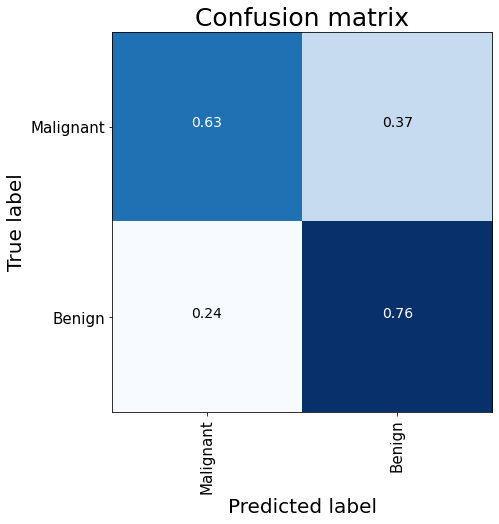

In [ ]:
for model in pretrained:
  test_loss, test_accuracy = model.evaluate(test_dataset)
  print(test_accuracy)
  pred_labels = (model.predict(test_dataset) > 0.5).astype("int32")
  conf_matrix = confusion_matrix(test_labels, pred_labels)
  print(sklearn.metrics.classification_report(test_labels, pred_labels))
  plt.figure(figsize=(7,7))
  plot_confusion_matrix( conf_matrix, classes=['Malignant','Benign'], title="Confusion matrix")
  plt.show()

11/11 [==============================] - 0s 16ms/step - loss: 0.6265 - acc: 0.6815
0.6815476417541504
              precision    recall  f1-score   support

           0       0.72      0.84      0.78       219
           1       0.56      0.38      0.45       117

    accuracy                           0.68       336
   macro avg       0.64      0.61      0.61       336
weighted avg       0.66      0.68      0.66       336



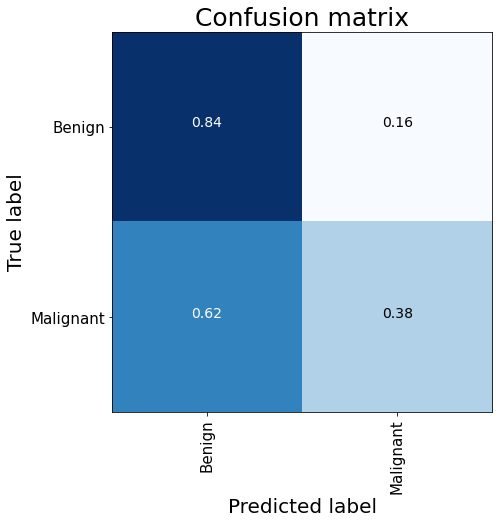

11/11 [==============================] - 1s 63ms/step - loss: 0.6251 - acc: 0.6280
0.6279761791229248
              precision    recall  f1-score   support

           0       0.78      0.59      0.68       219
           1       0.48      0.69      0.56       117

    accuracy                           0.63       336
   macro avg       0.63      0.64      0.62       336
weighted avg       0.68      0.63      0.64       336



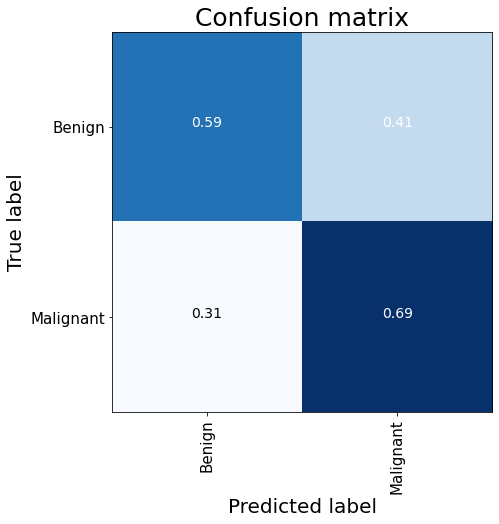

11/11 [==============================] - 0s 9ms/step - loss: 0.6176 - acc: 0.6369
0.636904776096344
              precision    recall  f1-score   support

           0       0.74      0.68      0.71       219
           1       0.48      0.55      0.51       117

    accuracy                           0.64       336
   macro avg       0.61      0.62      0.61       336
weighted avg       0.65      0.64      0.64       336



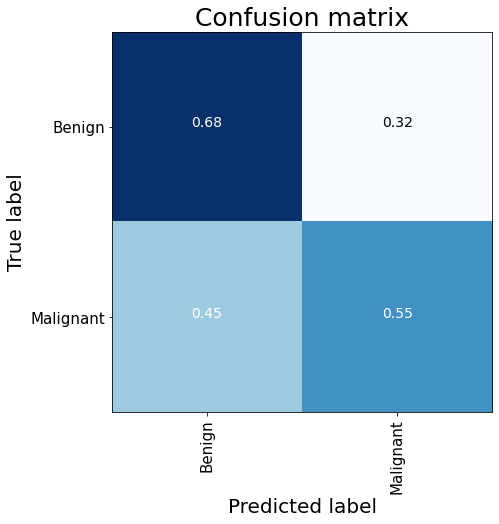

In [ ]:
for model in scratch:
  test_loss, test_accuracy = model.evaluate(test_dataset_1ch)
  print(test_accuracy)
  pred_labels = (model.predict(test_dataset_1ch) > 0.5).astype("int32")
  conf_matrix = confusion_matrix(test_labels_1ch, pred_labels)
  print(sklearn.metrics.classification_report(test_labels_1ch, pred_labels))
  plt.figure(figsize=(7,7))
  plot_confusion_matrix( conf_matrix, classes=['Benign','Malignant'], title="Confusion matrix")
  plt.show()

## Evaluation of Average Voting / Majority Voting ensemble Methods

In [ ]:
def avg_maj_votes(pretrained,scratch,test_dataset,test_dataset_1ch):
  preds_pret= [model.predict(test_dataset) for model in pretrained]
  preds_pret= np.array(preds_pret)
  pret_sum_pred=np.sum(preds_pret,axis=0)
  pret_votes=np.where(preds_pret > 0.5, 1, 0)
  pret_votes=np.sum(pret_votes,axis=0)


  scratch_preds= [model.predict(test_dataset_1ch) for model in scratch]
  scratch_preds= np.array(scratch_preds)
  scratch_preds= 1-scratch_preds
  scratch_sum_pred=np.sum(scratch_preds,axis=0)
  scratch_votes=np.where(scratch_preds > 0.5, 1, 0)
  scratch_votes=np.sum(scratch_votes,axis=0)
  avg_pred=(scratch_sum_pred+pret_sum_pred)/(len(scratch)+len(pretrained))
  vote=(pret_votes+scratch_votes)/(len(scratch)+len(pretrained))
  return avg_pred,vote

Accuracy: 0.7113095238095238
              precision    recall  f1-score   support

           0       0.59      0.54      0.57       117
           1       0.77      0.80      0.78       219

    accuracy                           0.71       336
   macro avg       0.68      0.67      0.67       336
weighted avg       0.71      0.71      0.71       336



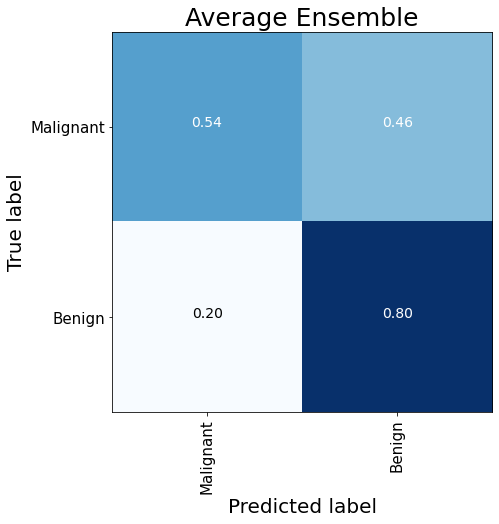

In [ ]:
avg_pred, vote= avg_maj_votes(pretrained,scratch,test_dataset,test_dataset_1ch)
pred_labels = (avg_pred > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
print("Accuracy: " + str(accuracy_score(test_labels, pred_labels)))
print(sklearn.metrics.classification_report(test_labels, pred_labels))
plt.figure(figsize=(7,7))
plot_confusion_matrix( conf_matrix, classes=['Malignant','Benign'], title="Average Ensemble")
plt.show()

Accuracy: 0.7023809523809523
              precision    recall  f1-score   support

           0       0.57      0.62      0.59       117
           1       0.79      0.74      0.77       219

    accuracy                           0.70       336
   macro avg       0.68      0.68      0.68       336
weighted avg       0.71      0.70      0.71       336



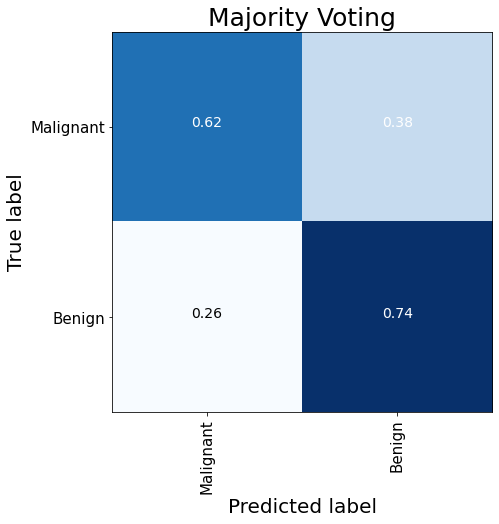

In [ ]:
pred_labels = (vote > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
print("Accuracy: " + str(accuracy_score(test_labels, pred_labels)))
print(sklearn.metrics.classification_report(test_labels, pred_labels))
plt.figure(figsize=(7,7))
plot_confusion_matrix( conf_matrix, classes=['Malignant','Benign'], title="Majority Voting")
plt.show()

## Weighted Average Ensemble On Pretrained_CNN results




https://machinelearningmastery.com/weighted-average-ensemble-for-deep-learning-neural-networks/

In [ ]:
def ensemble_predictions(members, weights, test):
	# make predictions
	yhats = [model.predict(test) for model in members]
	yhats = np.array(yhats)
	# weighted sum across ensemble members
	result = np.tensordot(yhats, weights, axes=((0),(0)))
	# argmax across classes
	return result

def evaluate_ensemble(members, weights, testset, testlab):
  # make prediction
  yhat = ensemble_predictions(members, weights, testset)
  pred_labels=(yhat > 0.5).astype("int32")
  return accuracy_score(testlab, pred_labels)

def normalize(weights):
  result=np.linalg.norm(weights,1)
  if result == 0.0:
	  return weights
  return weights/result

def grid_search(members, testset, testlab):
	# define weights to consider
	w = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
	best_score, best_weights = 0.0, None
	# iterate all possible combinations (cartesian product)
	for weights in itertools.product(w, repeat=len(members)):
		# skip if all weights are equal
		if len(set(weights)) == 1:
			continue
		# hack, normalize weight vector
		weights = normalize(weights)
		# evaluate weights
		score = evaluate_ensemble(members, weights, testset, testlab)
		if score > best_score:
			best_score, best_weights = score, weights
			print('>%s %.3f' % (best_weights, best_score))
	return list(best_weights)

In [ ]:
weights = [1.0/len(pretrained) for _ in range(len(pretrained))]
score = evaluate_ensemble(pretrained, weights, test_dataset, test_labels)
print("Same Weight Accuracy: " + str(score))
weights = grid_search(pretrained, test_dataset, test_labels)
score = evaluate_ensemble(pretrained, weights, test_dataset, test_labels)

Same Weight Accuracy: 0.7261904761904762
>[0. 0. 1.] 0.717
>[0.         0.33333333 0.66666667] 0.726
>[0.2 0.  0.8] 0.729
>[0.16666667 0.         0.83333333] 0.735


Weights: [0.16666666666666669, 0.0, 0.8333333333333334]
Accuracy: 0.7351190476190477
              precision    recall  f1-score   support

           0       0.61      0.64      0.63       117
           1       0.80      0.79      0.79       219

    accuracy                           0.74       336
   macro avg       0.71      0.71      0.71       336
weighted avg       0.74      0.74      0.74       336



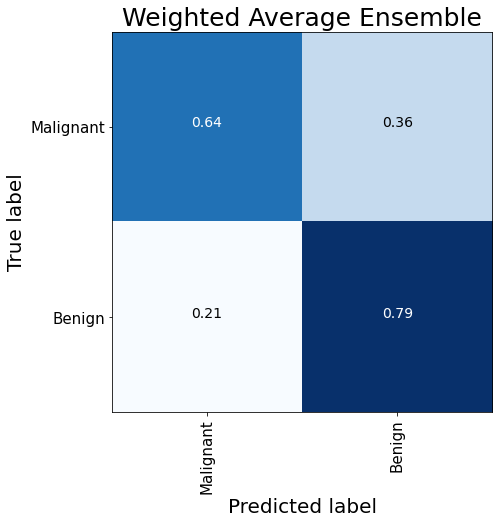

In [ ]:
print("Weights: " + str(weights))
res=ensemble_predictions(pretrained, weights, test_dataset)
pred_labels = (res > 0.5).astype("int32")
conf_matrix = confusion_matrix(test_labels, pred_labels)
print("Accuracy: " + str(accuracy_score(test_labels, pred_labels)))
print(sklearn.metrics.classification_report(test_labels, pred_labels))
plt.figure(figsize=(7,7))
plot_confusion_matrix( conf_matrix, classes=['Malignant','Benign'], title="Weighted Average Ensemble")
plt.show()

# 5.3 Submission and final considerations

The pretrained model from 3.2.3 VGG16 + WEIGHTING + INITIAL BIAS, USING 3-STAGE TUNING is the one chosen for submission even if it's ROC Curve is not dominating the others in all points.


In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

vote=1-vote
fpr_majority, tpr_majority, thresholds_majority = roc_curve(test_labels,vote,pos_label=0)
auc_majority = auc(fpr_majority, tpr_majority)

pred_vgg16=vgg_16_featextraction.predict(test_dataset)
pred_vgg16=1-pred_vgg16
fpr_vgg16fe, tpr_vgg16fe, thresholds_vgg16fe = roc_curve(test_labels,pred_vgg16,pos_label=0)
auc_vgg16fe = auc(fpr_vgg16fe, tpr_vgg16fe)

pred_vgg16we=vgg_16_ftweighted.predict(test_dataset)
pred_vgg16we=1-pred_vgg16we
fpr_vgg16we, tpr_vgg16we, thresholds_vgg16we = roc_curve(test_labels,pred_vgg16we,pos_label=0)
auc_vgg16we = auc(fpr_vgg16we, tpr_vgg16we)

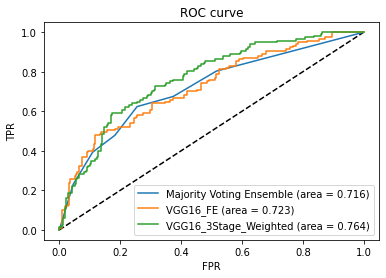

In [ ]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_majority, tpr_majority, label='Majority Voting Ensemble (area = {:.3f})'.format(auc_majority))
plt.plot(fpr_vgg16fe, tpr_vgg16fe, label='VGG16_FE (area = {:.3f})'.format(auc_vgg16fe))
plt.plot(fpr_vgg16we, tpr_vgg16we, label='VGG16_3Stage_Weighted (area = {:.3f})'.format(auc_vgg16we))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()


In [ ]:
test_images_private = np.load('/content/gdrive/My Drive/Balestri_Silvestri/numpy data/private_test_tensor.npy')

x_test_abno = test_images_private[1::2]
x_test_abno = x_test_abno/65535 
x_test_abno = np.repeat(x_test_abno[..., np.newaxis], 3, -1)
pred_vgg16we=vgg_16_ftweighted.predict(x_test_abno)
#since we had label 0 for malignant and 1 for benign, we consider as 1 the results <= 0.5
output_labels = np.where(pred_vgg16we > 0.5,0,1)
assert len(output_labels) == 336 # must be of this size!
with open('/content/gdrive/My Drive/Balestri_Silvestri/Submission.csv','w') as mf:
  mf.writelines("\n".join(str(i).replace('[', '').replace(']','') for i in output_labels) )